# **Ethnicity Detection from Face Data using Deep Learning**

# **Uploading and Extracting the Dataset**

In [1]:
# Uploading dataset
from google.colab import files

uploaded = files.upload()

Saving Testdata.zip to Testdata.zip
Saving Traindata.zip to Traindata.zip


In [2]:
#Extracting
from zipfile import ZipFile
file_name = "/content/Traindata.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [3]:
#Extracting
from zipfile import ZipFile
file_name = "/content/Testdata.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


# **Importing Libraries**

In [27]:
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, MaxPool2D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import os
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.preprocessing import image

In [5]:
img_size = (224, 224)

# **Data augmentation**

In [6]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [77]:
# Load training data
training_set = train_datagen.flow_from_directory(
    '/content/Traindata',
    target_size=img_size,
    batch_size=4,
    class_mode='binary',
        shuffle=True

)

Found 65 images belonging to 2 classes.


In [8]:
# Load testing data
test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(
    '/content/Testdata',
    target_size=img_size,
    batch_size=4,
    class_mode='binary',
    shuffle=False
)

Found 12 images belonging to 2 classes.


In [9]:
batch_images, batch_labels = next(training_set)

print("Batch of Images Shape:", batch_images.shape)

Batch of Images Shape: (4, 224, 224, 3)


# **Visualization**

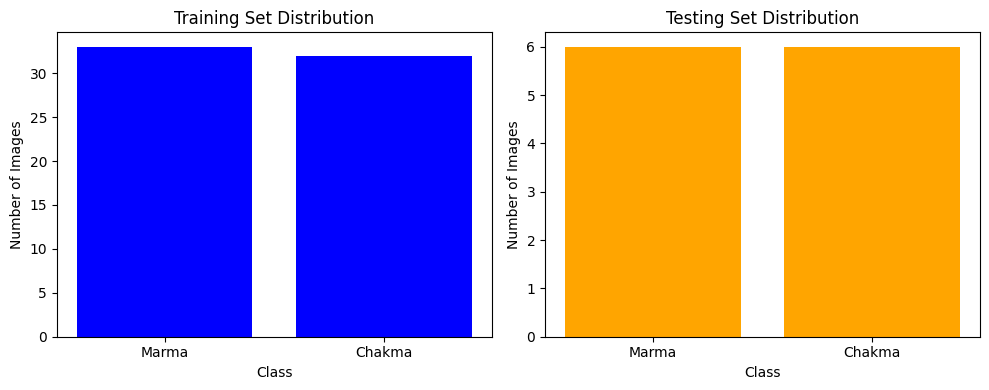

In [10]:
train_path = '/content/Traindata'
test_path = '/content/Testdata'

class_names = [class_name for class_name in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, class_name))]

train_counts = {class_name: len([file for file in os.listdir(os.path.join(train_path, class_name)) if file.endswith('.jpg') or file.endswith('.png')]) for class_name in class_names}
test_counts = {class_name: len([file for file in os.listdir(os.path.join(test_path, class_name)) if file.endswith('.jpg') or file.endswith('.png')]) for class_name in class_names}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.bar(class_names, train_counts.values(), color='blue')
ax1.set_title('Training Set Distribution')
ax1.set_xlabel('Class')
ax1.set_ylabel('Number of Images')

ax2.bar(class_names, test_counts.values(), color='orange')
ax2.set_title('Testing Set Distribution')
ax2.set_xlabel('Class')
ax2.set_ylabel('Number of Images')

plt.tight_layout()
plt.show()

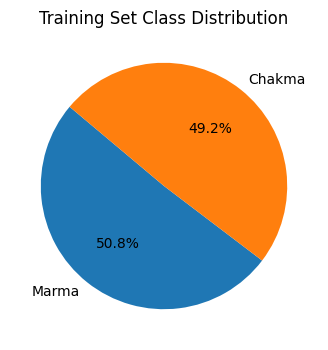

In [11]:
#Drawing PI Chart

plt.figure(figsize=(4, 4))
plt.pie((33,32), labels=class_names, autopct='%1.1f%%', startangle=140)
plt.title('Training Set Class Distribution')
plt.show()

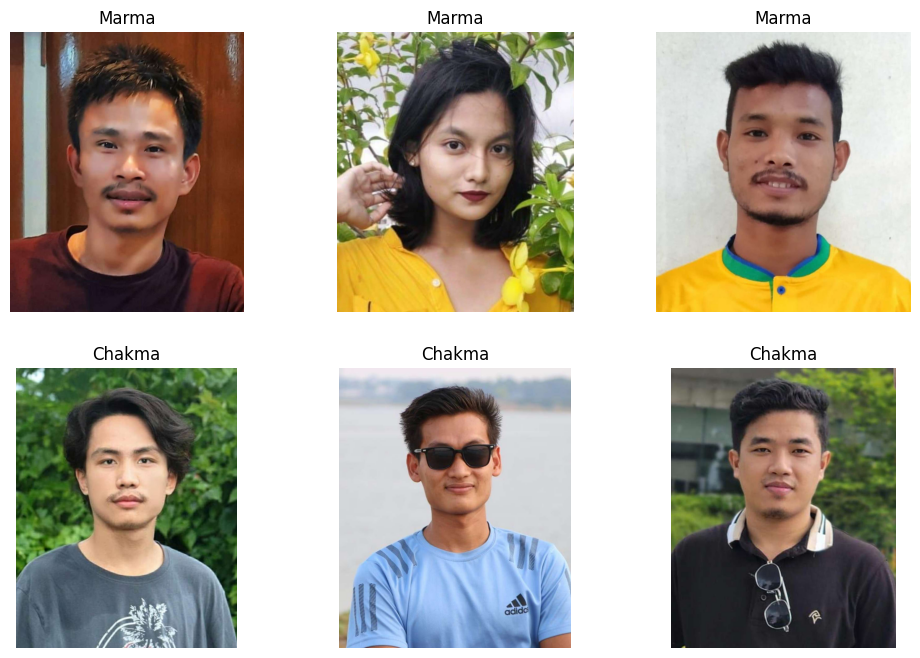

In [12]:
#Random Image from Training Set

import random
import matplotlib.image as mpimg

def plot_sample_images(directory, class_names, num_samples=3):
    plt.figure(figsize=(12, 8))
    for class_name in class_names:
        class_path = os.path.join(directory, class_name)
        image_files = [os.path.join(class_path, file) for file in os.listdir(class_path) if file.endswith(('jpg', 'jpeg', 'png'))]
        sample_images = random.sample(image_files, num_samples)

        for i, image_path in enumerate(sample_images, 1):
            plt.subplot(len(class_names), num_samples, (class_names.index(class_name) * num_samples) + i)
            img = mpimg.imread(image_path)
            plt.imshow(img)
            plt.axis('off')
            plt.title(class_name)

    plt.show()

plot_sample_images('/content/Traindata', class_names)

# **Basic CNN Model Building**

In [13]:
# Building the Basic CNN
model = Sequential()

In [14]:
model.add(Conv2D(32, (3, 3), input_shape=(img_size[0], img_size[1], 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

In [15]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [18]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# **Training**



In [19]:
checkpoint_path = '/content/mymodel.h5'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

history = model.fit(
    training_set,
    epochs=15,
    steps_per_epoch=len(training_set),
    validation_data=test_set,
    validation_steps=len(test_set),
    callbacks=[checkpoint],
    verbose=1
)

best_model = load_model(checkpoint_path)

Epoch 1/15
17/17 [==============================] - ETA: 0s - loss: 0.7530 - accuracy: 0.4154
Epoch 1: val_accuracy improved from -inf to 0.83333, saving model to /content/mymodel.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


17/17 [==============================] - 16s 771ms/step - loss: 0.7530 - accuracy: 0.4154 - val_loss: 0.6479 - val_accuracy: 0.8333
Epoch 2/15
17/17 [==============================] - ETA: 0s - loss: 0.6079 - accuracy: 0.6769
Epoch 2: val_accuracy did not improve from 0.83333
17/17 [==============================] - 12s 705ms/step - loss: 0.6079 - accuracy: 0.6769 - val_loss: 0.4646 - val_accuracy: 0.7500
Epoch 3/15
17/17 [==============================] - ETA: 0s - loss: 0.5850 - accuracy: 0.6769
Epoch 3: val_accuracy did not improve from 0.83333
17/17 [==============================] - 10s 597ms/step - loss: 0.5850 - accuracy: 0.6769 - val_loss: 0.4789 - val_accuracy: 0.8333
Epoch 4/15
17/17 [==============================] - ETA: 0s - loss: 0.4311 - accuracy: 0.8154
Epoch 4: val_accuracy did not improve from 0.83333
17/17 [==============================] - 12s 673ms/step - loss: 0.4311 - accuracy: 0.8154 - val_loss: 0.2755 - val_accuracy: 0.8333
Epoch 5/15
17/17 [===================

# **Testing**

1/1 [==============================] - 0s 146ms/step
Chakma


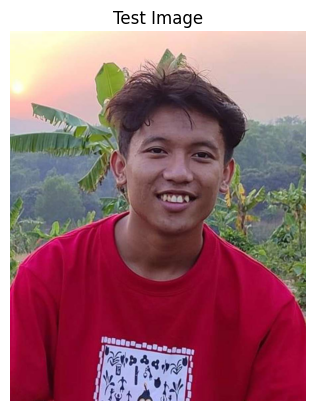

In [20]:
saved_model = load_model("/content/mymodel.h5")

img_path = "/content/Testdata/Chakma/C.jpg"
img = image.load_img(img_path, target_size=(img_size[0], img_size[1]))
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = img/255.

output = saved_model.predict(img)

if output[0][0] > 0.5:
    print("Marma")
else:
    print("Chakma")

plt.imshow(mpimg.imread(img_path))
plt.axis('off')
plt.title('Test Image')
plt.show()

# **Accuracy Evaluation**

In [21]:
# Evaluate
eval_result = model.evaluate(test_set, verbose=1)
print(f"Test loss: {eval_result[0]}, Test accuracy: {eval_result[1]}")

3/3 [==============================] - 0s 98ms/step - loss: 0.2363 - accuracy: 0.8333
Test loss: 0.23629923164844513, Test accuracy: 0.8333333134651184


3/3 [==============================] - 0s 104ms/step


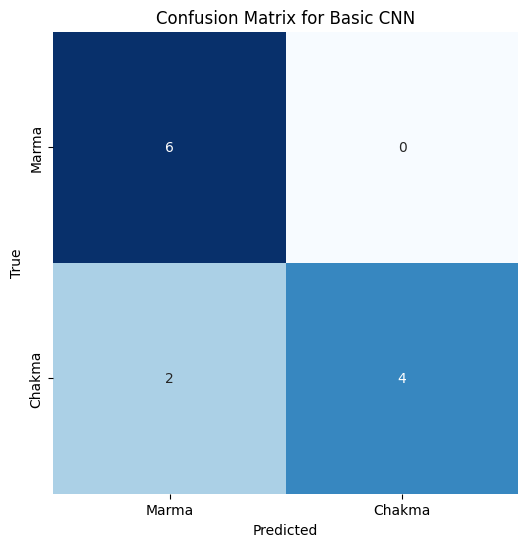

In [23]:
y_pred = model.predict(test_set)
y_pred = (y_pred > 0.5)

# Confusion matrix
cm = confusion_matrix(test_set.classes, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt. ylabel('True')
plt.title("Confusion Matrix for Basic CNN")
plt.show()

In [24]:
print(classification_report(test_set.classes, y_pred))  #classification report

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         6
           1       1.00      0.67      0.80         6

    accuracy                           0.83        12
   macro avg       0.88      0.83      0.83        12
weighted avg       0.88      0.83      0.83        12



# **Applying Pretrained Model VGG16**

In [114]:
# Load training data
training_set2 = train_datagen.flow_from_directory(
    '/content/Traindata',
    target_size=img_size,
    batch_size=16,
    class_mode='binary',
        shuffle=True

)

Found 65 images belonging to 2 classes.


In [115]:
# Load testing data
test_datagen = ImageDataGenerator(rescale=1./255)
test_set2 = test_datagen.flow_from_directory(
    '/content/Testdata',
    target_size=img_size,
    batch_size=6,
    class_mode='binary',
    shuffle=False
)

Found 12 images belonging to 2 classes.


# **Model Building**

In [97]:
model2 = Sequential()

In [98]:
model2.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
model2.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model2.add(MaxPooling2D((2, 2), strides=(2, 2)))

model2.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model2.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model2.add(MaxPooling2D((2, 2), strides=(2, 2)))

model2.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model2.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model2.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model2.add(MaxPooling2D((2, 2), strides=(2, 2)))

model2.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model2.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model2.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model2.add(MaxPooling2D((2, 2), strides=(2, 2)))

model2.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model2.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model2.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model2.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Fully connected layers
model2.add(Flatten())
model2.add(Dense(4096, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(4096, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(1, activation='softmax'))

In [99]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

opt = Adam(learning_rate=0.001)
model2.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [100]:
print(model2.summary())

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_85 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_86 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_38 (MaxPooli  (None, 112, 112, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_87 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_88 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_39 (MaxPooli  (None, 56, 56, 128)       0         
 ng2D)                                               

# **Training**

In [117]:
checkpoint_path2 = '/content/vgg16model.h5'
checkpoint2 = ModelCheckpoint(checkpoint_path2, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

history2 = model2.fit(
    training_set2,
    epochs=10,
    steps_per_epoch=len(training_set2),
    validation_data=test_set2,
    validation_steps=len(test_set2),
    callbacks=[checkpoint2,early_stopping],
    verbose=1
)

best_model2 = load_model(checkpoint_path2)

Epoch 1/10
5/5 [==============================] - ETA: 0s - loss: 0.0783 - accuracy: 0.9846
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to /content/vgg16model.h5
5/5 [==============================] - 11s 3s/step - loss: 0.0783 - accuracy: 0.9846 - val_loss: 0.0573 - val_accuracy: 1.0000
Epoch 2/10
5/5 [==============================] - ETA: 0s - loss: 0.2167 - accuracy: 0.9385
Epoch 2: val_accuracy did not improve from 1.00000
5/5 [==============================] - 9s 1s/step - loss: 0.2167 - accuracy: 0.9385 - val_loss: 0.3613 - val_accuracy: 0.8333
Epoch 3/10
5/5 [==============================] - ETA: 0s - loss: 0.1150 - accuracy: 0.9538
Epoch 3: val_accuracy did not improve from 1.00000
5/5 [==============================] - 9s 2s/step - loss: 0.1150 - accuracy: 0.9538 - val_loss: 0.0251 - val_accuracy: 1.0000
Epoch 4/10
5/5 [==============================] - ETA: 0s - loss: 0.2011 - accuracy: 0.8769
Epoch 4: val_accuracy did not improve from 1.00000
5/5 [===

# **Testing**

1/1 [==============================] - 0s 60ms/step
Chakma


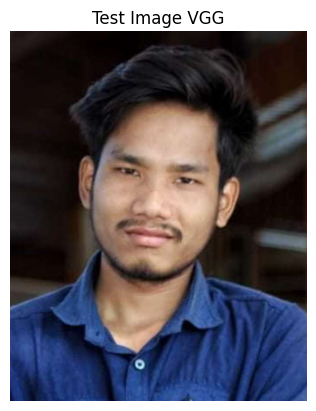

In [136]:
# Load the saved model
saved_model2 = load_model("/content/vgg16model.h5")

# Load an image from the test set
img_path = "/content/Testdata/Marma/M2.jpg"
img2 = image.load_img(img_path, target_size=(img_size[0], img_size[1]))
img2 = image.img_to_array(img2)
img2 = np.expand_dims(img, axis=0)
img2 = img/255.  # Normalize the pixel values

# Make predictions
output2 = model2.predict(img)

# Printing the class name based on the prediction
if output2[0][0] > 0.5:
    print("Marma")
else:
    print("Chakma")

plt.imshow(mpimg.imread(img_path))
plt.axis('off')
plt.title('Test Image VGG')
plt.show()

In [142]:
# Evaluate the VGG16 model on the testing set
eval_result2 = model2.evaluate(test_set2, verbose=1)
print(f"Test loss: {eval_result2[0]}, Test accuracy: {eval_result2[1]}")

2/2 [==============================] - 1s 266ms/step - loss: 0.0251 - accuracy: 1.0000
Test loss: 0.025079069659113884, Test accuracy: 1.0


2/2 [==============================] - 0s 156ms/step


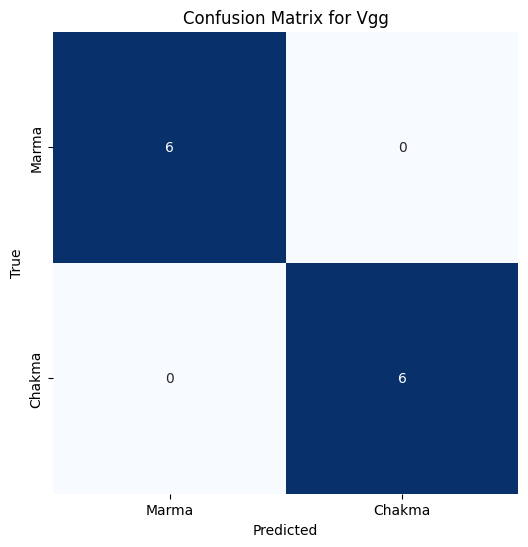

In [146]:
# Make predictions on the testing set
y_pred2 = model.predict(test_set2)
y_pred2 = (y_pred2 > 0.5)  # Convert probabilities to binary predictions

# Confusion matrix
cm2 = confusion_matrix(test_set.classes, y_pred2)
plt.figure(figsize=(6, 6))
sns.heatmap(cm2, annot=True, fmt="d", cmap="Blues", cbar=False,xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt. ylabel('True')
plt.title("Confusion Matrix for Vgg")
plt.show()

In [147]:
print(classification_report(test_set.classes, y_pred2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         6

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12



# **Comparison Between**

# **Basic CNN and VGG16**

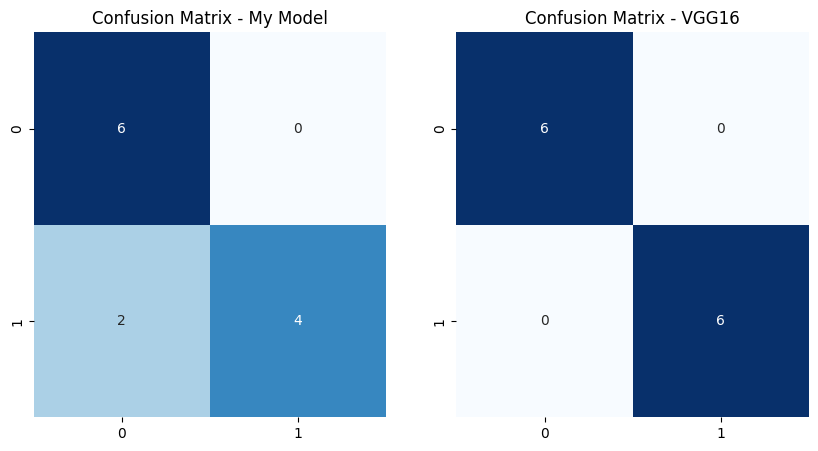

In [125]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix - My Model')

plt.subplot(1, 2, 2)
sns.heatmap(cm2, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix - VGG16')

plt.show()

# **Accuracy Comparison**

## **Comparison Table**

In [126]:
from tabulate import tabulate

model_names = ['My Model', 'VGG16']
headers = ['Model', 'Accuracy', 'Loss']

data = [
    ['Basic CNN', eval_result[1], eval_result[0]],
    ['VGG16', eval_result2[1], eval_result2[0]]
]

table = tabulate(data, headers=headers, tablefmt="pretty")

print(table)


+-----------+--------------------+----------------------+
|   Model   |      Accuracy      |         Loss         |
+-----------+--------------------+----------------------+
| Basic CNN | 0.8333333134651184 | 0.23629923164844513  |
|   VGG16   |        1.0         | 0.025079065933823586 |
+-----------+--------------------+----------------------+


## **Comparison Bar**

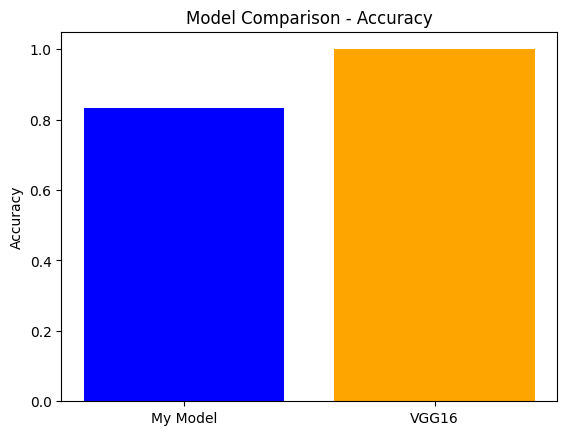

In [127]:
model_names = ['My Model', 'VGG16']
accuracies = [eval_result[1], eval_result2[1]]

plt.bar(model_names, accuracies, color=['blue', 'orange'])
plt.ylabel('Accuracy')
plt.title('Model Comparison - Accuracy')
plt.show()


# **Training and Validation Accuracy Curves**

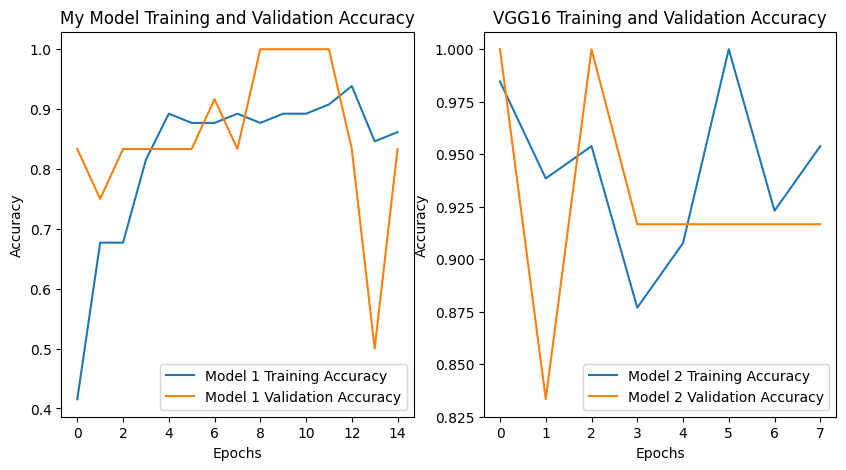

In [129]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Model 1 Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Model 1 Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('My Model Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history2.history['accuracy'], label='Model 2 Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Model 2 Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('VGG16 Training and Validation Accuracy')
plt.legend()

plt.show()

# **Thank You**